# Programming for Data Science and Artificial Intelligence

## Deep Learning -  PyTorch - Amazon Stock Prediction

### Time Series Forecasting

Time series forecasting is the application of a model to predict future values based on previously observed values. By definition, a time series is a series of data points indexed in time order. This type of problem is important because there is a variety of prediction problems that involve a time component, and finding the data/time relationship is key to the analysis (e.g. weather forecasting and earthquake prediction). 

Stock market prediction is the act of trying to determine the future value of a company stock. State of the art gets around 60-70% which is considered already high.

Given time series is a sequence, RNNs are commonly used.  Here we are going to build two different models of RNNs — LSTM and GRU — with PyTorch to predict Amazon’s stock market price and compare their performance in terms of time and efficiency.

Note that although LSTM is currently more popular, the GRU is bound to eventually outshine it due to a superior speed while achieving similar accuracy and effectiveness.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quandl
import datetime
start = datetime.datetime(2006,1,1)
end = datetime.date.today()
amz = quandl.get("WIKI/AMZN", start_date=start, end_date=end)
amz=amz[["Open","High","Low","Close","Volume"]]

In [2]:
print(amz.shape)
amz.head()

(3077, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,47.470,47.85,46.25,47.58,7582200.0
2006-01-04,47.485,47.73,46.69,47.25,7440900.0
2006-01-05,47.160,48.20,47.11,47.65,5417200.0
2006-01-06,47.970,48.58,47.32,47.87,6152900.0
2006-01-09,46.550,47.10,46.40,47.08,8943100.0


Let's try to plot the Amazon Stock Price

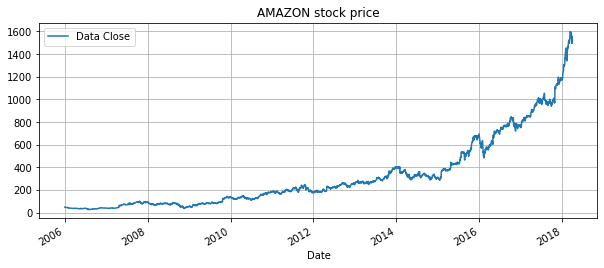

In [3]:
amz[['Close']].plot(figsize=(10,4),legend=True)
plt.legend(['Data Close'])
plt.title('AMAZON stock price')
plt.grid()
plt.show()

We slice the data frame to get the column we want and normalize the data.

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
price = scaler.fit_transform(amz[['Close']].values.reshape(-1, 1))

Now we split the data into train and test sets. Before doing so, we must define the window width of the analysis. The use of prior time steps to predict the next time step is called the sliding window method.

In [5]:
def split_data(price, window_size):
    data_raw = price
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - window_size): 
        data.append(data_raw[index: index + window_size])
    
    data = np.array(data)
    
    
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

window_size = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, window_size)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2446, 19, 1)
y_train.shape =  (2446, 1)
x_test.shape =  (611, 19, 1)
y_test.shape =  (611, 1)


Then we transform them into tensors, which is the basic structure for building a PyTorch model.

In [6]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

We define some common values for both models regarding the layers.

In [7]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

### LSTM

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

We create the model, set the criterion, and the optimiser.

In [9]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

Finally, we train the model over 100 epochs

In [10]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.873907744884491
Epoch  1 MSE:  0.5890175700187683
Epoch  2 MSE:  0.2838144600391388
Epoch  3 MSE:  0.030474653467535973
Epoch  4 MSE:  0.2361193150281906
Epoch  5 MSE:  0.15234829485416412
Epoch  6 MSE:  0.04570651799440384
Epoch  7 MSE:  0.022041212767362595
Epoch  8 MSE:  0.04545658081769943
Epoch  9 MSE:  0.06804568320512772
Epoch  10 MSE:  0.07306186109781265
Epoch  11 MSE:  0.06400541961193085
Epoch  12 MSE:  0.048865340650081635
Epoch  13 MSE:  0.0344979353249073
Epoch  14 MSE:  0.025179076939821243
Epoch  15 MSE:  0.0224077757447958
Epoch  16 MSE:  0.02514929138123989
Epoch  17 MSE:  0.030469050630927086
Epoch  18 MSE:  0.03485916182398796
Epoch  19 MSE:  0.036090534180402756
Epoch  20 MSE:  0.03408431634306908
Epoch  21 MSE:  0.030283696949481964
Epoch  22 MSE:  0.02647976391017437
Epoch  23 MSE:  0.02393466793000698
Epoch  24 MSE:  0.023076940327882767
Epoch  25 MSE:  0.023638205602765083
Epoch  26 MSE:  0.024976838380098343
Epoch  27 MSE:  0.02639364451169967

Let's plot the loss.  Also let's inverse transform the scale back to the original scale

In [11]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

In [12]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Amazon Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Amazon Stock Price')
    plt.title('Amazon Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Amazon Stock Price')
    plt.legend()
    plt.show()
    
def plot_loss(hist):
    plt.plot(hist, color='red')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

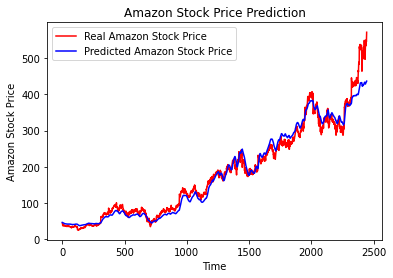

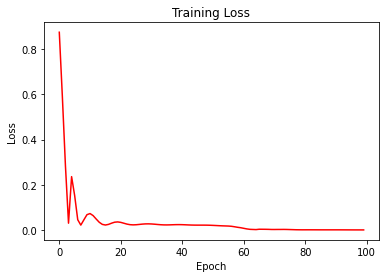

In [13]:
plot_predictions(original, predict)
plot_loss(hist)

Let's print the MSE of the training and testing

In [14]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 21.85 RMSE
Test Score: 433.50 RMSE


### GRU

In [15]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [16]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5568073987960815
Epoch  1 MSE:  0.2549295127391815
Epoch  2 MSE:  0.053372204303741455
Epoch  3 MSE:  0.06295347213745117
Epoch  4 MSE:  0.09281086176633835
Epoch  5 MSE:  0.0341060608625412
Epoch  6 MSE:  0.020864788442850113
Epoch  7 MSE:  0.04440856724977493
Epoch  8 MSE:  0.054317351430654526
Epoch  9 MSE:  0.04272213950753212
Epoch  10 MSE:  0.025462262332439423
Epoch  11 MSE:  0.018017705529928207
Epoch  12 MSE:  0.024225277826189995
Epoch  13 MSE:  0.032666027545928955
Epoch  14 MSE:  0.03170403465628624
Epoch  15 MSE:  0.023724019527435303
Epoch  16 MSE:  0.017343496903777122
Epoch  17 MSE:  0.01679708994925022
Epoch  18 MSE:  0.020085563883185387
Epoch  19 MSE:  0.02290887013077736
Epoch  20 MSE:  0.022571828216314316
Epoch  21 MSE:  0.01935628056526184
Epoch  22 MSE:  0.015612540766596794
Epoch  23 MSE:  0.01375972107052803
Epoch  24 MSE:  0.014454787597060204
Epoch  25 MSE:  0.016135836020112038
Epoch  26 MSE:  0.016514398157596588
Epoch  27 MSE:  0.01477517

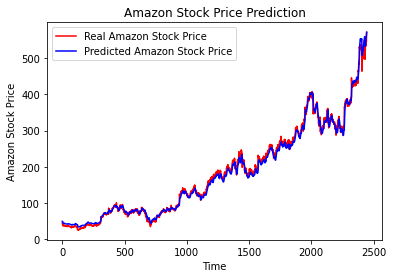

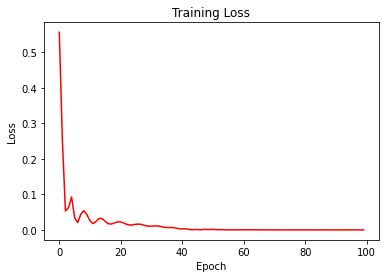

In [18]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))
plot_predictions(original, predict)
plot_loss(hist)

In [19]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 8.50 RMSE
Test Score: 53.40 RMSE
